# Cplex python API example
The use of Cplex in python will here be explained by defining, solving and processing the output of an optimal control problem (OCP).

To start using the Cplex python API first import it and import numpy for array handling and matplotlib for plotting

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cplex

A new optimization problem can be created with:

In [2]:
ocp = cplex.Cplex()

We will define some parameters to use in the example, the values are of no importance.

In [3]:
# number of time points in the OCP
N = 25
dt = 3600.
time = np.arange(N)*dt

# prediction dictionary
pre = {'T_in_min': 20*np.ones(N),
       'T_em_max': 30*np.ones(N),
       'T_amb': 5 + 5*np.sin(2*np.pi*(time/24/3600-0.6)),
       'Q_flow_hp_max': 5000*np.ones(N),
       'Q_flow_sol': np.clip(2000*np.sin(2*np.pi*(time/24/3600-0.4)),0,10000),
       'p_el': np.clip( 0.18 + 0.10*np.sin(2*np.pi*(time/24/3600-0.0)),0,0.24 )}

# parameter dictionary
par = {'COP': 4,
       'C_in': 10e6,
       'C_em': 20e6,
       'UA_in_amb': 200,
       'UA_em_in': 1600}

## Variables
Variable must be added to the problem using the `cplex.variables.add` method. This method has several keyword arguments  all of which must all be a list of values.

All supplied arguments must have equal length. Arguments are:
- `names`: list of strings, variable names which can be used to reference the variable
- `obj`: list of floats, coefficient of the linear objective function accompanying the variable
- `lb`: list of floats, lower bounds of the variables, defaults to 0
- `ub`: list of floats, upper bounds of the variables, defaults to 1e20
- `type`: list of single character strings 'C','I','B' for continuous, integer and binary variables respectively.
Cplex is suitable for solving Mixed Integer Programs.

When defining an optimal control problem is is easy to use list comprehensions built into python together with string formatting to generate meaningful names for all variables.
These names will then refer to the correct column in the constraint and objective matrices.

In [4]:
ocp.variables.add(names = ['Q_flow_hp[{0}]'.format(i) for i in range(N)])
ocp.variables.add(names = ['T_in[{0}]'.format(i) for i in range(N)])
ocp.variables.add(names = ['T_em[{0}]'.format(i) for i in range(N)])

Boundaries for the variables can be set during variable creation or using the methods `cplex.variable.set_lower_bounds` and `cplex.variable.set_upper_bounds`.
These methods accept either a variable name/index, value pair or a list of variable name/index, value pair tuples. Again using list comprehensions makes everything easy.
It is preferred to make few calls of a function with a larger set of variables than the other way around as this reduced overhead.

In [5]:
ocp.variables.set_lower_bounds( 'T_in[0]',pre['T_in_min'][0] )
# or
ocp.variables.set_lower_bounds( [('T_in[{0}]'.format(i)     ,pre['T_in_min'][i]) for i in range(N)] )
ocp.variables.set_upper_bounds( [('Q_flow_hp[{0}]'.format(i),pre['Q_flow_hp_max'][i]) for i in range(N)]
                               +[('T_em[{0}]'.format(i)     ,pre['T_em_max'][i]) for i in range(N)] )

For most "set" methods in cplex there is a corresponding "get" method which can be used to retrieve values.

## Objective
The objective function can have linear and quadratic terms quadratic, cplex will select an appropriate solution method automatically.

The linear terms in the objective function can be defined using `cplex.objective.set_linear`.
This function accepts the same input argument format as the `cplex.variables.set_lower_bounds` method explained above.

In [6]:
ocp.objective.set_linear( 'Q_flow_hp[0]', par['COP']*pre['p_el'][0]/1000*dt/3600 )
# or
ocp.objective.set_linear( [('Q_flow_hp[{0}]'.format(i), par['COP']*pre['p_el'][i]/1000*dt/3600) for i in range(N)] )

Quadratic terms in the objective function are easiest to define with `cplex.objective.set_quadratic_coefficients`.
Now 3 arguments or a list of tuples of 3 must be given containing two variables and the value. 
Of course care must be taken that the quadratic part remains positive semidefinite or the problem will become non-convex.
In the example below a small cost is given to the square of some variables:

In [7]:
ocp.objective.set_quadratic_coefficients( [('Q_flow_hp[%s]'%(i),'Q_flow_hp[%s]'%(i),0.01*par['COP']*pre['p_el'][i]/1000*dt/3600) for i in range(N)] )

## Constraints
Both linear and quadratic constraints can be defined and reside in separate attributes.

Linear constraints can be added to the problem with `cplex.linear_constraints.add`.
It accepts the following keyword arguments:
- lin_expr: list of matrices in list of lists format or a list of cplex sparce pairs, expresses the lhs of the constraint
- senses: list of single character strings which, expresses the sense of the constraint, 'G','L','E','R' for Greater, Lesser, Equal and Ranged respectively 
- rhs: list of floats, specifies the rhs of the constraints
- range_values: list of floats specifying a range for the rhs if range_values[i] > 0 : rhs[i] <= a*x <= rhs[i]+range_values[i] else rhs[i]+range_values[i] <= a*x <= rhs[i]
- names: a list of strings, names for the constraints

A custom cplex type has come up, the `cplex.SparsePair`. This type assigns values to an index which is referred to.
The example below can be used to assign values to the row of `T_in[0]` and `T_in[1]` in some constraint:

In [8]:
cplex.SparsePair(ind = ['T_in[0]', 'T_in[1]'], val = [5.0, 6.5])

SparsePair(ind = ['T_in[0]', 'T_in[1]'], val = [5.0, 6.5])

For the optimal control problem at hand the equations have to be discretized manually (leaving you the freedom to choose how to discretize).
Again list comprehensions are useful when adding constraints to our problem:

In [9]:
# state constraints for T_in
# C_in/dt*(T_in[i+1]-T_in[i]) = UA_in_amb*(T_amb[i]-T_in[i]) + UA_em_in*(T_em[i]-T_in[i]) + Q_flow_sol[i]


ocp.linear_constraints.add( lin_expr = [ [['T_in[{0}]'.format(i)                           , 'T_in[{0}]'.format(i+1), 'T_em[{0}]'.format(i) ],
                                          [-par['C_in']/dt+par['UA_in_amb']+par['UA_em_in'], par['C_in']/dt         , -par['UA_em_in']      ]] for i in range(N-1)],
                            senses   = ['E' for i in range(N-1)],
                            rhs      = [par['UA_in_amb']*pre['T_amb'][i] + pre['Q_flow_sol'][i] for i in range(N-1)],
                            names    = ['state_T_in[{0}]'.format(i) for i in range(N-1)] )

# or
# state constraints for T_em
# C_em/dt*(T_em[i+1]-T_em[i]) = UA_em_in*(T_in[i]-T_em[i]) + Q_flow_hp[i]
ocp.linear_constraints.add( lin_expr = [ cplex.SparsePair( ind = ['T_em[{0}]'.format(i)          , 'T_em[{0}]'.format(i+1), 'T_in[{0}]'.format(i) , 'Q_flow_hp[{0}]'.format(i) ], 
                                                           val = [-par['C_em']/dt+par['UA_em_in'], par['C_em']/dt         , -par['UA_em_in']      , -1                         ]
                                                          ) for i in range(N-1)],
                            senses   = ['E' for i in range(N-1)],
                            rhs      = [0 for i in range(N-1)],
                            names    = ['state_T_em[{0}]'.format(i) for i in range(N-1)] )

Our problem also needs initial values which are also equality constraints:

In [10]:
# add initial values
ocp.linear_constraints.add(lin_expr = [[['T_in[0]'],
                                        [1        ]]],
                           senses   = 'E',
                           rhs      = [21],
                           names    = ['T_in_ini'])

ocp.linear_constraints.add(lin_expr = [[['T_em[0]'],
                                        [1        ]]],
                           senses   = 'E',
                           rhs      = [22],
                           names    = ['T_em_ini'])

When using the OCP in a model predictive control strategy it is common that the bounds and right hand side of constraints change.
As this is only a small change in the large OCP it is appropriate to only change this part of the OCP reducing unnecessary computations.
This can be done with the `cplex.linear_constraints.set_rhs` method.
It accepts a list of tuples containing a constraint name/index and a value just like `cplex.variable.set_lower_bounds` and `cplex.objective.set_linear` :

In [11]:
ocp.linear_constraints.set_rhs( [('state_T_in[{0}]'.format(i),par['UA_in_amb']*pre['T_amb'][i] + pre['Q_flow_sol'][i]) for i in range(N-1)]  
                               +[('state_T_em[{0}]'.format(i),0) for i in range(N-1)] )

## Solving and retrieving the solution

Solving is easy:

In [12]:
ocp.solve()

Tried aggregator 1 time.
QP Presolve eliminated 3 rows and 7 columns.
Aggregator did 4 substitutions.
Reduced QP has 43 rows, 64 columns, and 151 nonzeros.
Reduced QP objective Q matrix has 23 nonzeros.
Presolve time = 0.01 sec. (0.04 ticks)
Parallel mode: using up to 4 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 103
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.01 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 4
  Rows in Factor            = 43
  Integer space required    = 47
  Total non-zeros in factor = 386
  Total FP ops to factor    = 4222
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0  6.6832806e+005 -6.6726646e+005 1.02e+003 5.00e+002 1.19e+005
   1  4.9425743e+004 -4.9333080e+004 2.73e+002 1.33e+002 3.18e+004
   2  2.4922498e+004 -2.4288434e+004 1.75e+002 8.53e+001 2.04e+004
   3  3.4887657e+003 -2.5924761e+003 4.62e+001 2.26e+001 5.39e+003
   4

cplex does the rest.

You can suppress output if required with the following commands:

In [13]:
ocp.set_log_stream(None)
ocp.set_error_stream(None)
ocp.set_warning_stream(None)
ocp.set_results_stream(None)

Retrieving the solution is equally easy.
Pay attention though that cplex returns regular lists, not numpy arrays, best to convert them immediately:

In [14]:
sol = {}
sol['Q_flow_hp'] = np.array(ocp.solution.get_values(['Q_flow_hp[{0}]'.format(i) for i in range(N)]))
sol['T_in']      = np.array(ocp.solution.get_values(['T_in[{0}]'.format(i) for i in range(N)]))
sol['T_em']     = np.array(ocp.solution.get_values(['T_em[{0}]'.format(i) for i in range(N)]))
print(sol['T_in'])

[ 21.          20.63560269  20.66868564  20.65789637  20.58312991
  20.4745934   20.35731675  20.24211609  20.13887337  20.05675946  20.          20.
  20.          20.          20.03173812  20.11351282  20.22883109
  20.35779649  20.47934991  20.56951709  20.60026288  20.54368185
  20.38056326  20.1801851   20.        ]


And finally we can plot the results of our optimal control problem

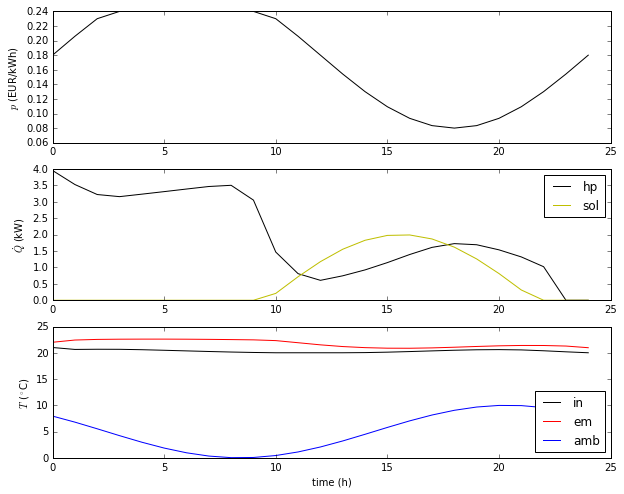

In [15]:
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(10,8))
ax[0].plot(time/3600,pre['p_el'],'k',label='p')
ax[0].set_ylabel('$p$ (EUR/kWh)')

ax[1].plot(time/3600,sol['Q_flow_hp']/1000.,'k',label='hp')
ax[1].plot(time/3600,pre['Q_flow_sol']/1000.,'y',label='sol')
ax[1].set_ylabel('$\dot{Q}$ (kW)')
ax[1].legend(loc='upper right')

ax[2].plot(time/3600,sol['T_in'],'k',label='in')
ax[2].plot(time/3600,sol['T_em'],'r',label='em')
ax[2].plot(time/3600,pre['T_amb'],'b',label='amb')
ax[2].set_ylabel('$T$ ($^\circ$C)')
ax[2].set_xlabel('time (h)')
ax[2].legend(loc='lower right')